##Importing and preprocessing the dataset

In [1]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time

In [2]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
def preprocess_images(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

In [4]:
train_size = 60000
batch_size = 32
test_size = 10000

In [5]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

##A. 1. Basic Vanilla VAE model implementation

In [6]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

In [7]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [8]:
epochs = 10
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [9]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [10]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

Epoch: 10, Test set ELBO: -157.56301879882812, time elapse for current epoch: 8.055445194244385


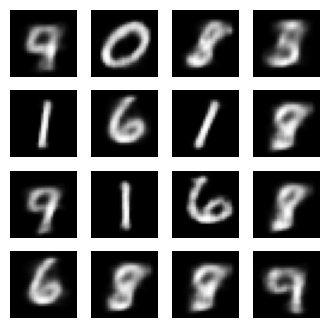

In [11]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)

In [12]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

(-0.5, 399.5, 399.5, -0.5)

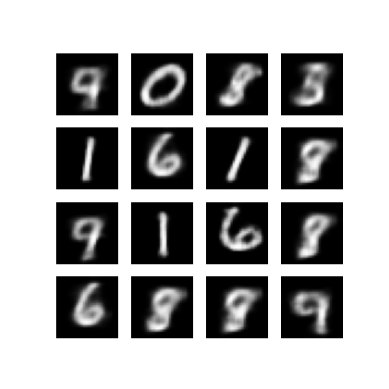

In [13]:
plt.imshow(display_image(epoch))
plt.axis('off')  # Display images

In [14]:
anim_file = 'cvae1.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-14-2c902c6cafcb>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-14-2c902c6cafcb>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [15]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-v0bm55hn
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-v0bm55hn
  Resolved https://github.com/tensorflow/docs to commit 460419a6369bd00bfc3ce7a7c92b0ca2a832c91b
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2024.7.15.51478-py3-none-any.whl size=182586 sha256=1e0bde080d37425fe41930fc303a226a9ad76383f56298bb485f52a7a371db7d
  Stored in directory: /tmp/pip-ephem-wheel-cache-axjk72k0/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs



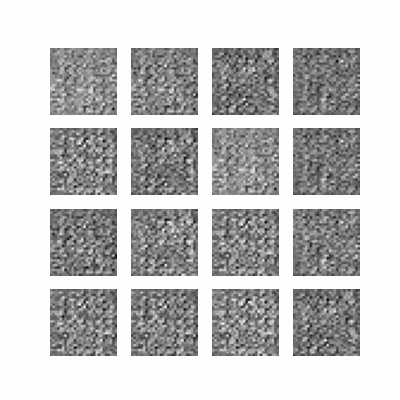

In [16]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

##2. Changing the Encoder to an Encoder-Decoder Architecture

In [17]:
class CVAE_2(tf.keras.Model):
    """VAE with Encoder-Decoder architecture as Encoder."""

    def __init__(self, latent_dim):
        super(CVAE_2, self).__init__()
        self.latent_dim = latent_dim

        # Encoder-Decoder architecture for the encoder part
        self.encoder_decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
                # Downsampling
                tf.keras.layers.Conv2D(32, 3, strides=(2, 2), activation='relu', padding='same'),
                tf.keras.layers.Conv2D(64, 3, strides=(2, 2), activation='relu', padding='same'),
                tf.keras.layers.Conv2D(128, 3, strides=(2, 2), activation='relu', padding='same'),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(128, activation='relu'),
                # Bottleneck (latent space representation)
                tf.keras.layers.Dense(7 * 7 * 128, activation='relu'),
                tf.keras.layers.Reshape((7, 7, 128)),
                # Upsampling
                tf.keras.layers.Conv2DTranspose(128, 3, strides=2, activation='relu', padding='same'),
                tf.keras.layers.Conv2DTranspose(64, 3, strides=2, activation='relu', padding='same'),
                tf.keras.layers.Conv2DTranspose(32, 3, strides=2, activation='relu', padding='same'),
                tf.keras.layers.Conv2DTranspose(1, 3, strides=1, padding='same'),
                tf.keras.layers.Flatten(),
                # No activation for latent space
                tf.keras.layers.Dense(latent_dim + latent_dim)
            ]
        )

        # Decoder remains the same
        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
                tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
                tf.keras.layers.Conv2DTranspose(
                    filters=64, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                tf.keras.layers.Conv2DTranspose(
                    filters=32, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                # No activation
                tf.keras.layers.Conv2DTranspose(
                    filters=1, kernel_size=3, strides=1, padding='same'),
            ]
        )

    def call(self, inputs):
        # Encode input to latent space
        encoded = self.encoder_decoder(inputs)
        # Split latent space into mean and log-variance
        mean, logvar = tf.split(encoded, num_or_size_splits=2, axis=1)
        return mean, logvar

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = self.call(x)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=tf.shape(mean))
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

# Instantiate the model
latent_dim = 2
model = CVAE_2(latent_dim)


In [18]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [19]:
epochs = 10
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE_2(latent_dim)

In [20]:
def generate_and_save_images_2(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_2_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [21]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

Epoch: 10, Test set ELBO: -145.325927734375, time elapse for current epoch: 17.4734308719635


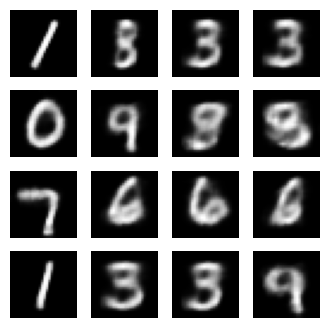

In [22]:
generate_and_save_images_2(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images_2(model, epoch, test_sample)

In [23]:
def display_image_2(epoch_no):
  return PIL.Image.open('image_2_at_epoch_{:04d}.png'.format(epoch_no))

(-0.5, 399.5, 399.5, -0.5)

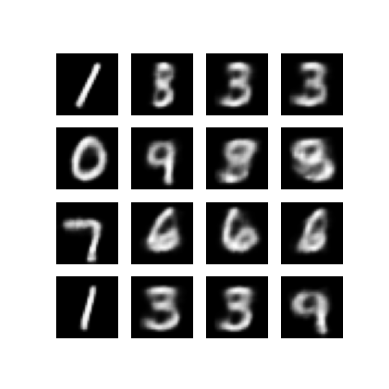

In [24]:
plt.imshow(display_image_2(epoch))
plt.axis('off')  # Display images

In [25]:
anim_file = 'cvae2.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image_2*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-25-f2399fed895a>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-25-f2399fed895a>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


##3. Changing the Decoder to an Encoder-Decoder Architecture

In [36]:
class CVAE_3(tf.keras.Model):
    """VAE with vanilla encoder and Encoder-Decoder architecture as Decoder."""

    def __init__(self, latent_dim):
        super(CVAE_3, self).__init__()
        self.latent_dim = latent_dim

        # Vanilla encoder
        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
                tf.keras.layers.Conv2D(32, 3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Conv2D(64, 3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(128, activation='relu'),
                # No activation for latent space
                tf.keras.layers.Dense(latent_dim + latent_dim)
            ]
        )

        # Encoder-Decoder architecture for the decoder part
        self.decoder_encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                tf.keras.layers.Dense(units=7 * 7 * 32, activation='relu'),
                tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
                # Downsampling
                tf.keras.layers.Conv2D(64, 3, strides=2, activation='relu', padding='same'),
                tf.keras.layers.Conv2D(128, 3, strides=2, activation='relu', padding='same'),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(128, activation='relu'),
                # Bottleneck (latent space representation)
                tf.keras.layers.Dense(7 * 7 * 128, activation='relu'),
                tf.keras.layers.Reshape((7, 7, 128)),
                # Upsampling
                tf.keras.layers.Conv2DTranspose(128, 3, strides=2, activation='relu', padding='same'),
                tf.keras.layers.Conv2DTranspose(64, 3, strides=2, activation='relu', padding='same'),
                tf.keras.layers.Conv2DTranspose(32, 3, strides=1, activation='relu', padding='same'),
                tf.keras.layers.Conv2DTranspose(1, 3, strides=1, padding='same')
            ]
        )

    def call(self, inputs):
        # Encode input to latent space
        encoded = self.encoder(inputs)
        # Split latent space into mean and log-variance
        mean, logvar = tf.split(encoded, num_or_size_splits=2, axis=1)
        return mean, logvar

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = self.call(x)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=tf.shape(mean))
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder_encoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

# Instantiate the model
latent_dim = 2
model = CVAE_3(latent_dim)


In [37]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [38]:
epochs = 10
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE_3(latent_dim)

In [39]:
def generate_and_save_images_3(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_3_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

Epoch: 10, Test set ELBO: -142.83706665039062, time elapse for current epoch: 13.64205527305603


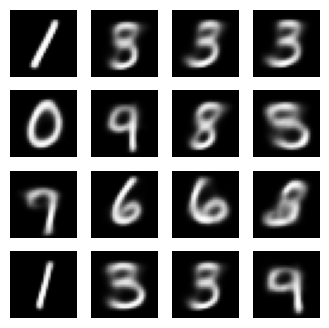

In [40]:
generate_and_save_images_3(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images_3(model, epoch, test_sample)

In [41]:
def display_image_3(epoch_no):
  return PIL.Image.open('image_3_at_epoch_{:04d}.png'.format(epoch_no))

(-0.5, 399.5, 399.5, -0.5)

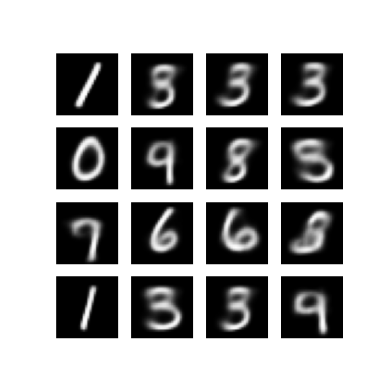

In [42]:
plt.imshow(display_image_3(epoch))
plt.axis('off')  # Display images

In [43]:
anim_file = 'cvae3.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image_3*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-43-c53a5a2e94f7>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-43-c53a5a2e94f7>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


##4. Changing both the Encoder and Decoder to an Encoder-Decoder Architecture

In [52]:
class CVAE_4(tf.keras.Model):
    """VAE with Encoder-Decoder architectures for both Encoder and Decoder."""

    def __init__(self, latent_dim):
        super(CVAE_4, self).__init__()
        self.latent_dim = latent_dim

        # Encoder-Decoder architecture for the encoder part
        self.encoder_decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
                # Downsampling
                tf.keras.layers.Conv2D(32, 3, strides=(2, 2), activation='relu', padding='same'),
                tf.keras.layers.Conv2D(64, 3, strides=(2, 2), activation='relu', padding='same'),
                tf.keras.layers.Conv2D(128, 3, strides=(2, 2), activation='relu', padding='same'),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(128, activation='relu'),
                # Bottleneck (latent space representation)
                tf.keras.layers.Dense(7 * 7 * 128, activation='relu'),
                tf.keras.layers.Reshape((7, 7, 128)),
                # Upsampling
                tf.keras.layers.Conv2DTranspose(128, 3, strides=2, activation='relu', padding='same'),
                tf.keras.layers.Conv2DTranspose(64, 3, strides=2, activation='relu', padding='same'),
                tf.keras.layers.Conv2DTranspose(32, 3, strides=2, activation='relu', padding='same'),
                tf.keras.layers.Conv2DTranspose(1, 3, strides=1, padding='same'),
                tf.keras.layers.Flatten(),
                # No activation for latent space
                tf.keras.layers.Dense(latent_dim + latent_dim)
            ]
        )

        # Encoder-Decoder architecture for the decoder part
        self.decoder_encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                tf.keras.layers.Dense(units=7 * 7 * 32, activation='relu'),
                tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
                # Downsampling
                tf.keras.layers.Conv2D(64, 3, strides=2, activation='relu', padding='same'),
                tf.keras.layers.Conv2D(128, 3, strides=2, activation='relu', padding='same'),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(128, activation='relu'),
                # Bottleneck (latent space representation)
                tf.keras.layers.Dense(7 * 7 * 128, activation='relu'),
                tf.keras.layers.Reshape((7, 7, 128)),
                # Upsampling
                tf.keras.layers.Conv2DTranspose(128, 3, strides=2, activation='relu', padding='same'),
                tf.keras.layers.Conv2DTranspose(64, 3, strides=2, activation='relu', padding='same'),
                tf.keras.layers.Conv2DTranspose(32, 3, strides=1, activation='relu', padding='same'),
                tf.keras.layers.Conv2DTranspose(1, 3, strides=1, padding='same')
            ]
        )

    def call(self, inputs):
        # Encode input to latent space
        encoded = self.encoder_decoder(inputs)
        # Split latent space into mean and log-variance
        mean, logvar = tf.split(encoded, num_or_size_splits=2, axis=1)
        return mean, logvar

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = self.call(x)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=tf.shape(mean))
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder_encoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

# Instantiate the model
latent_dim = 2
model = CVAE_4(latent_dim)


In [53]:
epochs = 10
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE_4(latent_dim)

In [54]:
def generate_and_save_images_4(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_4_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [58]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

Epoch: 10, Test set ELBO: -140.47776794433594, time elapse for current epoch: 24.610986471176147


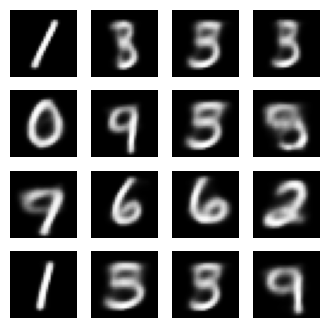

In [59]:
generate_and_save_images_4(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images_4(model, epoch, test_sample)

In [60]:
def display_image_4(epoch_no):
  return PIL.Image.open('image_4_at_epoch_{:04d}.png'.format(epoch_no))

(-0.5, 399.5, 399.5, -0.5)

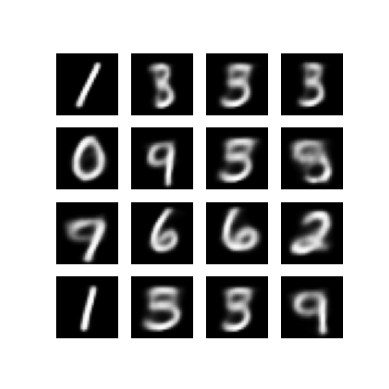

In [61]:
plt.imshow(display_image_4(epoch))
plt.axis('off')  # Display images

In [62]:
anim_file = 'cvae4.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image_4*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-62-b070b0b1f2ee>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-62-b070b0b1f2ee>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


##Comparing Results

At Epoch 1 -

(-0.5, 399.5, 399.5, -0.5)

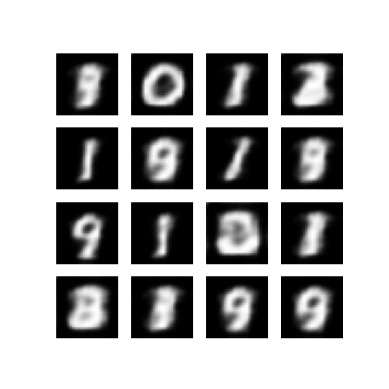

In [64]:
plt.imshow(display_image(1))
plt.axis('off')

(-0.5, 399.5, 399.5, -0.5)

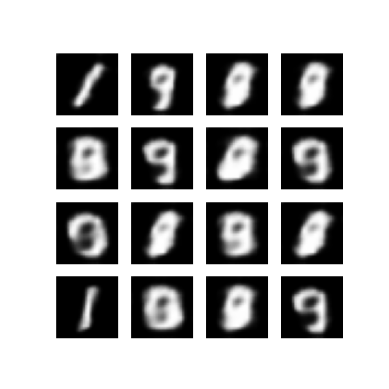

In [68]:
plt.imshow(display_image_2(1))
plt.axis('off')

(-0.5, 399.5, 399.5, -0.5)

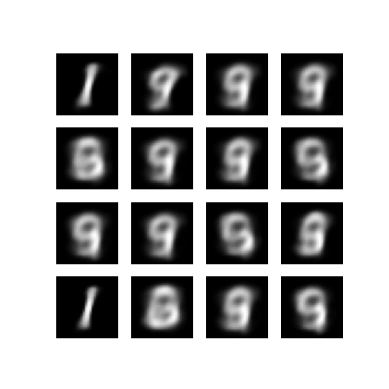

In [69]:
plt.imshow(display_image_3(1))
plt.axis('off')

(-0.5, 399.5, 399.5, -0.5)

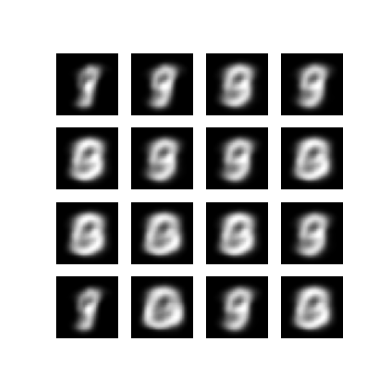

In [70]:
plt.imshow(display_image_4(1))
plt.axis('off')

At epoch 5 -

(-0.5, 399.5, 399.5, -0.5)

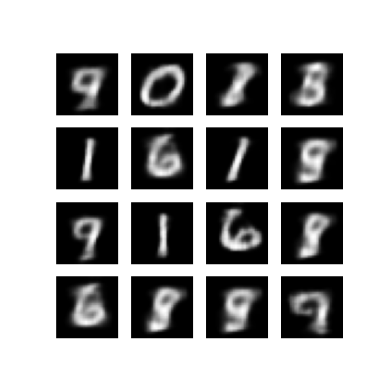

In [72]:
plt.imshow(display_image(5))
plt.axis('off')

(-0.5, 399.5, 399.5, -0.5)

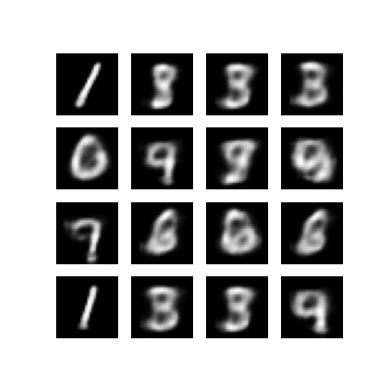

In [73]:
plt.imshow(display_image_2(5))
plt.axis('off')

(-0.5, 399.5, 399.5, -0.5)

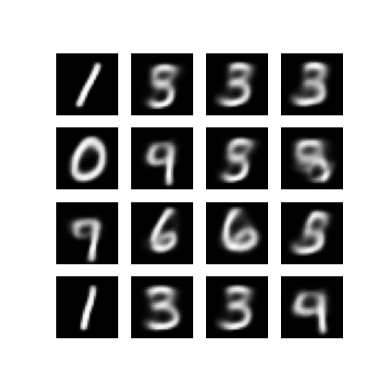

In [74]:
plt.imshow(display_image_3(5))
plt.axis('off')

(-0.5, 399.5, 399.5, -0.5)

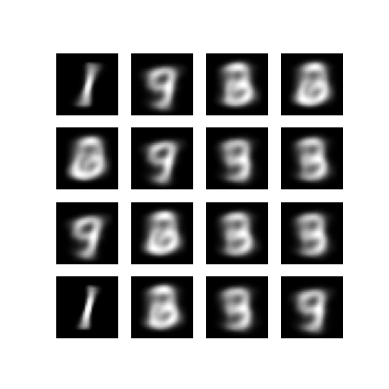

In [71]:
plt.imshow(display_image_4(5))
plt.axis('off')

At epoch 10 -

(-0.5, 399.5, 399.5, -0.5)

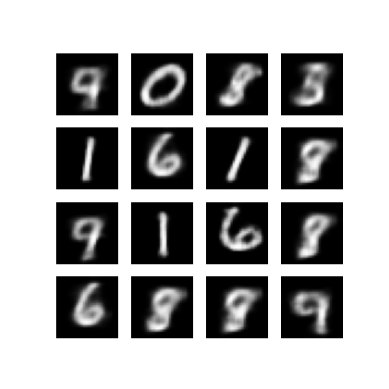

In [75]:
plt.imshow(display_image(10))
plt.axis('off')

(-0.5, 399.5, 399.5, -0.5)

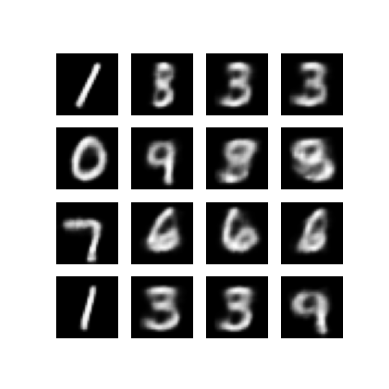

In [76]:
plt.imshow(display_image_2(10))
plt.axis('off')

(-0.5, 399.5, 399.5, -0.5)

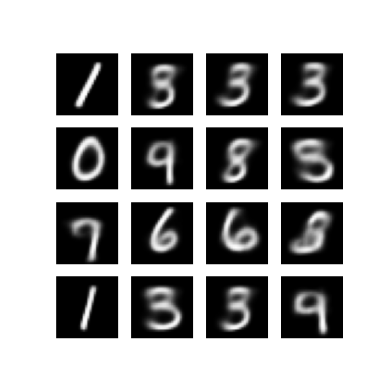

In [77]:
plt.imshow(display_image_3(10))
plt.axis('off')

(-0.5, 399.5, 399.5, -0.5)

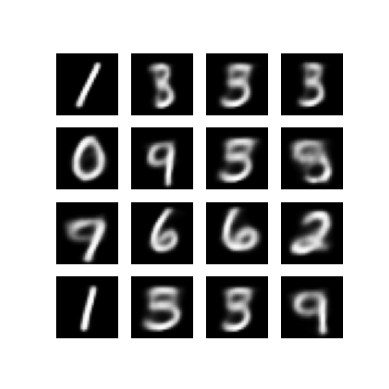

In [78]:
plt.imshow(display_image_4(10))
plt.axis('off')

Comparing the Gifs -


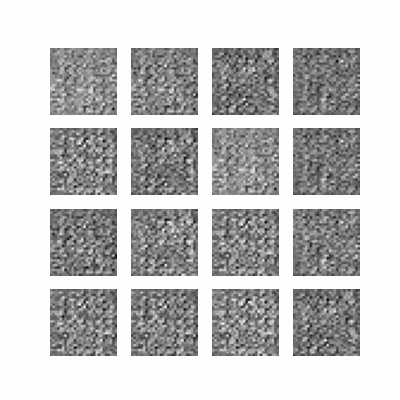

In [80]:
import tensorflow_docs.vis.embed as embed
embed.embed_file('cvae1.gif')


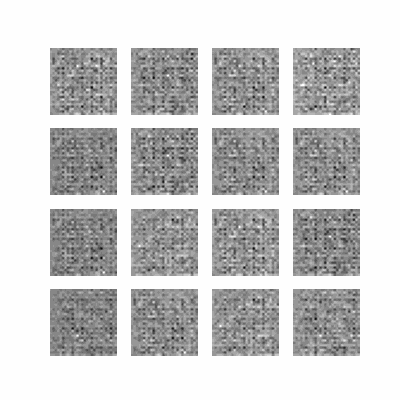

In [81]:
embed.embed_file('cvae2.gif')


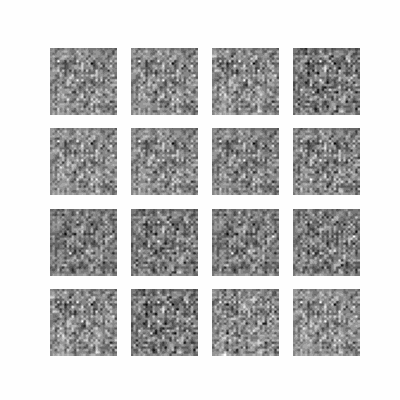

In [82]:
embed.embed_file('cvae3.gif')


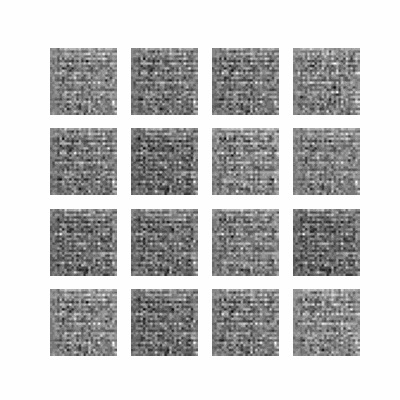

In [83]:
embed.embed_file('cvae4.gif')

The best architecture was the fourth one (VAE with Encoder-Decoder on both sides). It turned out to be the best in terms of both accuracy and output image quality. The complex structures on both the encoder and decoder sides enabled better feature extraction and image reconstruction.

The second and third architectures performed better than the original VAE but had trade-offs depending on whether the complexity was in the encoder or decoder.

The original VAE served as a good starting point but was outperformed by the more complex variants.